In [1]:
# notebook adapted from https://muon-tutorials.readthedocs.io/en/latest/single-cell-rna-atac/brain3k/1-Processing-and-Integration.html

In [200]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import sys
import os
from pathlib import Path
import muon as mu
import mudatasets
import seaborn as sns

In [201]:
# import requires setting a PYTHONPATH with the data_import directory
import h5ad_preparation as prep

In [202]:
mdata = mudatasets.load("brain3k_multiome", data_dir=prep.basedir, full=True)

■ File filtered_feature_bc_matrix.h5 from brain3k_multiome has been found at /Users/ggayq/projects/cellenium/scratch/brain3k_multiome/filtered_feature_bc_matrix.h5
■ Checksum is validated (md5) for filtered_feature_bc_matrix.h5
■ File atac_fragments.tsv.gz from brain3k_multiome has been found at /Users/ggayq/projects/cellenium/scratch/brain3k_multiome/atac_fragments.tsv.gz
■ Checksum is validated (md5) for atac_fragments.tsv.gz
■ File atac_fragments.tsv.gz.tbi from brain3k_multiome has been found at /Users/ggayq/projects/cellenium/scratch/brain3k_multiome/atac_fragments.tsv.gz.tbi
■ Checksum is validated (md5) for atac_fragments.tsv.gz.tbi
■ File atac_peaks.bed from brain3k_multiome has been found at /Users/ggayq/projects/cellenium/scratch/brain3k_multiome/atac_peaks.bed
■ Checksum is validated (md5) for atac_peaks.bed
■ File atac_peak_annotation.tsv from brain3k_multiome has been found at /Users/ggayq/projects/cellenium/scratch/brain3k_multiome/atac_peak_annotation.tsv
■ Checksum is v

/Users/ggayq/opt/anaconda3/envs/cellenium_import/lib/python3.10/site-packages/mudatasets/core.py:203: UserWarning: Dataset is in the 10X .h5 format and can't be loaded as backed.
  warn("Dataset is in the 10X .h5 format and can't be loaded as backed.")
/Users/ggayq/opt/anaconda3/envs/cellenium_import/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Added `interval` annotation for features from /Users/ggayq/projects/cellenium/scratch/brain3k_multiome/filtered_feature_bc_matrix.h5


/Users/ggayq/opt/anaconda3/envs/cellenium_import/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/ggayq/opt/anaconda3/envs/cellenium_import/lib/python3.10/site-packages/mudata/_core/mudata.py:446: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(
/Users/ggayq/opt/anaconda3/envs/cellenium_import/lib/python3.10/site-packages/mudata/_core/mudata.py:671: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/Users/ggayq/opt/anaconda3/envs/cellenium_import/lib/python3.10/site-packages/mudata/_core/mudata.py:671: FutureWarning: In a future versio

Added peak annotation from /Users/ggayq/projects/cellenium/scratch/brain3k_multiome/atac_peak_annotation.tsv to .uns['atac']['peak_annotation']
Added gene names to peak annotation in .uns['atac']['peak_annotation']
Located fragments file: /Users/ggayq/projects/cellenium/scratch/brain3k_multiome/atac_fragments.tsv.gz


In [203]:
mdata.var_names_make_unique()

# RNA

In [204]:
rna = mdata['rna']

In [205]:
prep.make_sparse(rna)

In [206]:
rna.var['mt'] = rna.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [207]:
# filter
mu.pp.filter_obs(rna, 'n_genes_by_counts', lambda x: (x >= 200) & (x < 8000))
mu.pp.filter_obs(rna, 'total_counts', lambda x: x < 40000)
mu.pp.filter_obs(rna, 'pct_counts_mt', lambda x: x < 2)

In [208]:
# normalize
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)

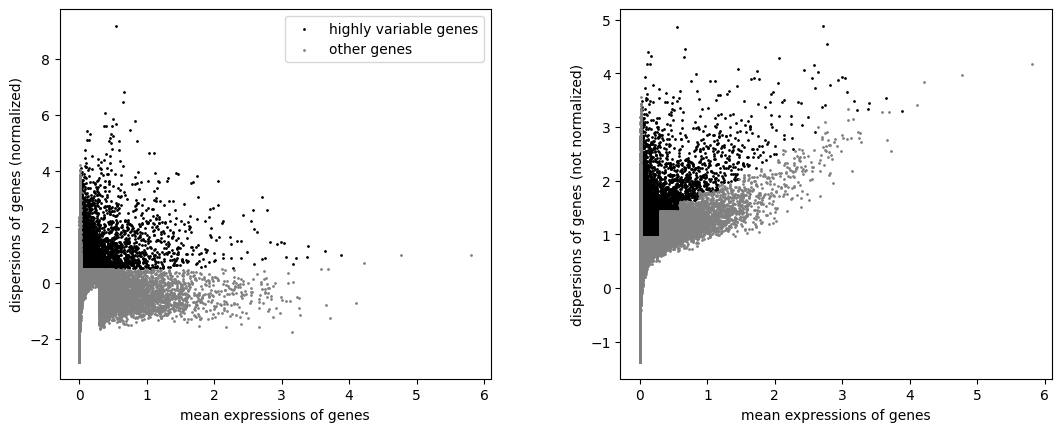

In [209]:
# Prepare umap
sc.pp.highly_variable_genes(rna, min_mean=0.02, max_mean=4, min_disp=0.5)
sc.pl.highly_variable_genes(rna)

In [210]:
#subset down to 10 % of the samples
rna.obs['take'] = pd.np.random.uniform(size=rna.obs.shape[0]) <= 0.1
mu.pp.filter_obs(rna, 'take')
#subset down to 1 % of the genes
rna.var['take'] = pd.np.random.uniform(size=rna.var.shape[0]) <= 0.01
mu.pp.filter_var(rna, 'take')

/var/folders/vd/x21hzjmn3dlcqwv40849_mjc0000gq/T/ipykernel_34112/1469532489.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  rna.obs['take'] = pd.np.random.uniform(size=rna.obs.shape[0]) <= 0.1
/var/folders/vd/x21hzjmn3dlcqwv40849_mjc0000gq/T/ipykernel_34112/1469532489.py:5: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  rna.var['take'] = pd.np.random.uniform(size=rna.var.shape[0]) <= 0.01


In [211]:
# save the lognorm
rna.layers["lognorm"] = rna.X.copy()

In [212]:
sc.pp.scale(rna, max_value=10)

In [213]:
sc.tl.pca(rna, svd_solver='arpack')

In [214]:
# clustering
sc.pp.neighbors(rna, n_neighbors=10, n_pcs=20)
sc.tl.leiden(rna, resolution=.5)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


... storing 'feature_types' as categorical
... storing 'genome' as categorical
/Users/ggayq/opt/anaconda3/envs/cellenium_import/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


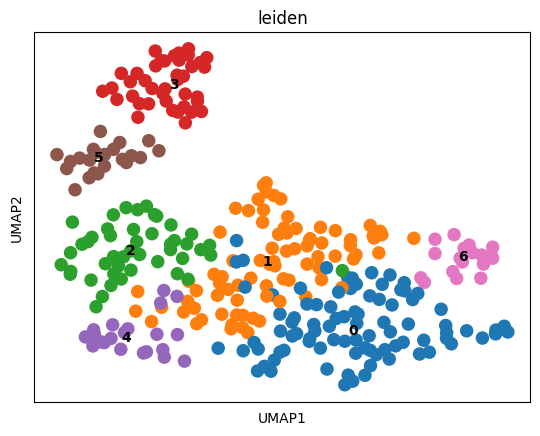

In [215]:
# umap
sc.tl.umap(rna, spread=1., min_dist=.5, random_state=11)
sc.pl.umap(rna, color="leiden", legend_loc="on data")

In [216]:
rna.obs['celltype'] = rna.obs['leiden']

In [217]:
rna.X = rna.layers['lognorm']

In [218]:
prep.calculate_differentially_expressed_genes(rna, ['celltype'])

diff.exp. genes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.43it/s]
20230224-102726.793 34112 INFO root:359 calculate_differentially_expressed_genes: found a list of genes for these attributes: ['celltype']


,names,scores,logfoldchanges,pvals,pvals_adj,ref_attr_value,cmp_attr_value,attribute_name
0,ANKIB1,4.449322,0.910494,0.000009,0.001538,0,_OTHERS_,celltype
1,FAM124A,3.539758,1.011577,0.000400,0.023829,0,_OTHERS_,celltype
2,INSYN2B,3.376050,1.315152,0.000735,0.032815,0,_OTHERS_,celltype
3,RNF144A,3.331897,0.820952,0.000863,0.034215,0,_OTHERS_,celltype
4,INPP1,3.235438,1.359988,0.001215,0.040366,0,_OTHERS_,celltype
...,...,...,...,...,...,...,...,...
176,HNRNPL,0.480363,0.597686,0.630969,1.000000,6,_OTHERS_,celltype
177,ZFP64,0.472445,0.668658,0.636609,1.000000,6,_OTHERS_,celltype
178,GEMIN2,0.353674,0.900967,0.723583,1.000000,6,_OTHERS_,celltype
179,DPH5,0.306166,0.710028,0.759479,1.000000,6,_OTHERS_,celltype


In [219]:
prep.remove_raw_and_layers(rna)

# ATAC

In [220]:
from muon import atac as ac

In [221]:
atac = mdata.mod['atac']

In [222]:
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)

In [223]:
# filter
mu.pp.filter_obs(atac, 'total_counts', lambda x: (x >= 1000) & (x <= 80000))
mu.pp.filter_obs(atac, 'n_genes_by_counts', lambda x: (x >= 100) & (x <= 30000))

In [224]:
tss = ac.tl.tss_enrichment(mdata, n_tss=1000)  # by default, features=ac.tl.get_gene_annotation_from_rna(mdata)

Fetching Regions...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [00:01<00:00, 180.12it/s]


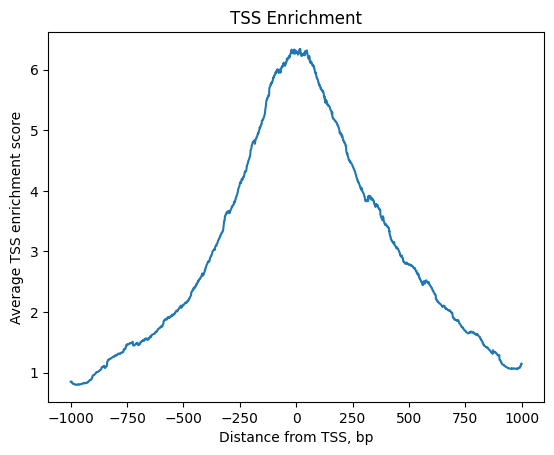

In [225]:
ac.pl.tss_enrichment(tss)

In [226]:
# normalisation
sc.pp.normalize_total(atac, target_sum=1e4)
sc.pp.log1p(atac)
atac.layers['lognorm'] = atac.X

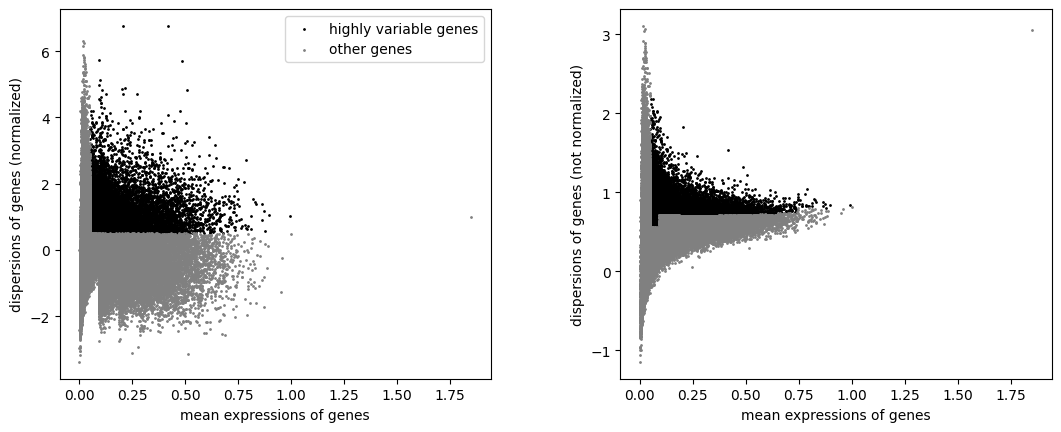

In [227]:
# variable regions
sc.pp.highly_variable_genes(atac, min_mean=0.05, max_mean=1.5, min_disp=.5)
sc.pl.highly_variable_genes(atac)

In [228]:
#subset down to 10 % of the samples
atac.obs['take'] = pd.np.random.uniform(size=atac.obs.shape[0]) <= 0.1
mu.pp.filter_obs(atac, 'take')
#subset down to 1 % of the genes
atac.var['take'] = pd.np.random.uniform(size=atac.var.shape[0]) <= 0.01
mu.pp.filter_var(atac, 'take')

/var/folders/vd/x21hzjmn3dlcqwv40849_mjc0000gq/T/ipykernel_34112/481395927.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  atac.obs['take'] = pd.np.random.uniform(size=atac.obs.shape[0]) <= 0.1
/var/folders/vd/x21hzjmn3dlcqwv40849_mjc0000gq/T/ipykernel_34112/481395927.py:5: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  atac.var['take'] = pd.np.random.uniform(size=atac.var.shape[0]) <= 0.01


In [229]:
# prepare umap
sc.pp.scale(atac, max_value=10)
sc.tl.pca(atac, svd_solver='arpack')

In [230]:
# clustering
sc.pp.neighbors(atac, n_neighbors=10, n_pcs=20)
sc.tl.leiden(atac, resolution=.5)

In [231]:
# umap
sc.tl.umap(atac, spread=1., min_dist=.5, random_state=11)

... storing 'feature_types' as categorical
... storing 'genome' as categorical
/Users/ggayq/opt/anaconda3/envs/cellenium_import/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


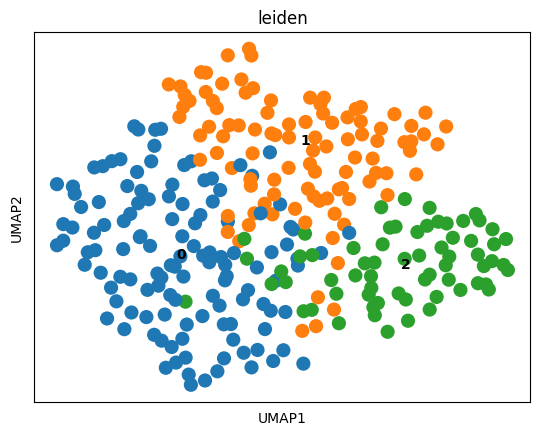

In [232]:
sc.pl.umap(atac, color="leiden", legend_loc="on data")

In [233]:
# assign new names
atac.obs['celltype'] = atac.obs['leiden']
atac.obs.celltype = atac.obs.celltype.astype("category")

In [234]:
from matplotlib.colors import to_hex
import matplotlib.pyplot as plt

cmap = plt.get_cmap('rainbow')
colors = cmap(np.linspace(0, 1, len(atac.obs.celltype.cat.categories)))

atac.uns["celltype_colors"] = list(map(to_hex, colors))

/Users/ggayq/opt/anaconda3/envs/cellenium_import/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


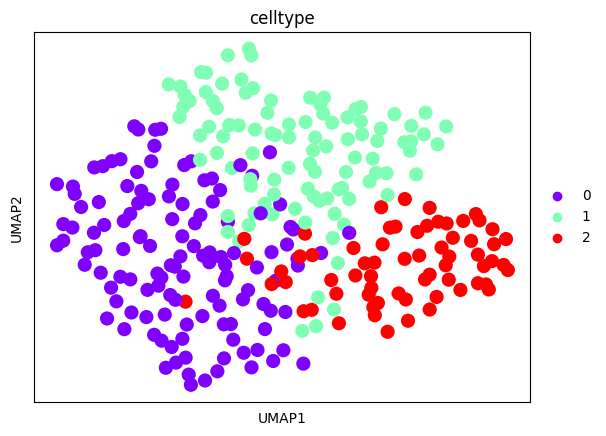

In [235]:
sc.pl.umap(atac, color="celltype")

In [236]:
prep.remove_raw_and_layers(atac)

In [237]:
mdata.update()

/Users/ggayq/opt/anaconda3/envs/cellenium_import/lib/python3.10/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/Users/ggayq/opt/anaconda3/envs/cellenium_import/lib/python3.10/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [238]:
atac.uns['files'] = dict(atac.uns['files'])
atac.uns['atac'] = dict(atac.uns['atac'])

In [239]:
prep.calculate_differential_peaks(atac, ['celltype'])

differential peaks:   0%|                                                                                                                   | 0/1 [00:00<?, ?it/s]/Users/ggayq/opt/anaconda3/envs/cellenium_import/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/ggayq/opt/anaconda3/envs/cellenium_import/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/ggayq/opt/anaconda3/envs/cellenium_import/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
differential peaks: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.74it/s]
20230224-

,names,scores,logfoldchanges,pvals,pvals_adj,ref_attr_value,cmp_attr_value,attribute_name
0,chr12:39442909-39443802,3.791648,NaN,0.000150,0.090341,0,_OTHERS_,celltype
1,chr4:17810354-17811252,3.756639,NaN,0.000172,0.090341,0,_OTHERS_,celltype
2,chr8:144465286-144466172,3.709485,NaN,0.000208,0.090341,0,_OTHERS_,celltype
3,chr4:38867325-38868178,3.319389,NaN,0.000902,0.285055,0,_OTHERS_,celltype
4,chr14:35897530-35898332,3.256516,NaN,0.001128,0.285055,0,_OTHERS_,celltype
...,...,...,...,...,...,...,...,...
295,chr11:14539699-14540488,1.637509,NaN,0.101524,0.998650,2,_OTHERS_,celltype
296,chr3:8784690-8785611,1.634123,NaN,0.102233,0.998650,2,_OTHERS_,celltype
297,chr14:94971456-94972373,1.630738,NaN,0.102946,0.998650,2,_OTHERS_,celltype
298,chr17:78168182-78169015,1.598581,NaN,0.109914,0.998650,2,_OTHERS_,celltype


In [240]:
prep.set_cellenium_metadata(
    mdata,
    title='3k Brain Cells Multiomics subset',
    description='Frozen human healthy brain tissue provided by 10X Genomics',
    taxonomy_id=9606,
    ncit_tissue_ids=['C12439'],
    mesh_disease_ids=[],
    X_pseudolayer_name='norm_log_expression',
    modalities = {'atac':'region','rna':'gene'},
    main_sample_attributes={'atac':['celltype'], 'rna': ['celltype']}
)

In [42]:
mdata.write(prep.basedir / "brain3k_processed_subset.h5mu")

/Users/ggayq/opt/anaconda3/envs/cellenium_import/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
... storing 'feature_types' as categorical


In [43]:
# to be removed